In [80]:
#!/usr/bin/env python3
"""
Example configuration file for PFN training.
This is a Hebo+ prior configuration, as found in the PFNs4BO paper.
This file demonstrates how to configure the MainConfig for training using Python.
"""

import math

import torch
from pfns.model import bar_distribution
from pfns.model.encoders import EncoderConfig, StyleEncoderConfig
from pfns.priors.hyperparameter_sampling import ChoiceDistConfig, UniformFloatDistConfig
from pfns.priors.prior import AdhocPriorConfig
from pfns.train import (
    BatchShapeSamplerConfig,
    MainConfig,
    OptimizerConfig,
    TransformerConfig,
)
from pfns.utils import product_dict

from tqdm import tqdm

config_dicts = product_dict(
    {
        "sampled_hp_prior": [True, False],
        "emsize": [128, 256],
        "nlayers": [8],
        "epochs": [400],
        "lr": [1e-4, 2e-4],
        "batch_size": [128, 512],
    }
)


def get_config(config_index: int):
    config_dict = list(config_dicts)[config_index]

    sampled_hp_prior = config_dict["sampled_hp_prior"]
    emsize = config_dict["emsize"]
    epochs = config_dict["epochs"]
    lr = config_dict["lr"]
    nlayers = config_dict["nlayers"]
    batch_size = config_dict["batch_size"]

    num_workers = 12
    steps_per_epoch = 10

    def get_prior_config(sampled_hp_prior=sampled_hp_prior, plotting=False):
        hyperparameters = {
            "lengthscale_mean": 0.7958,  # uniform dist
            "lengthscale_std": 0.7233,  # uniform dist
            "outputscale_mean": 2.1165,  # uniform dist
            "outputscale_std": 2.3021,  # uniform dist
            "add_linear_kernel": False,  # dist as likelihood
            "unused_feature_likelihood": 0.3,  # dist, uniform 0. to .6
            "observation_noise": True,  # dist
            "x_sampler": "normal",  # fixed
            "batch_size_per_gp_sample": 8,
            "hebo_noise_logmean": -4.63,
            "hebo_noise_std": 0.5,
        }
        if sampled_hp_prior:
            hyperparameters.update(
                {
                    "num_hyperparameter_samples_per_batch": -1,
                    "hyperparameter_sampling_add_hps_to_style": "all_sampled",
                    "hyperparameter_sampling_skip_style_prob": 0.1,
                }
            )
            hyperparameters["lengthscale_mean"] = UniformFloatDistConfig(0.5, 1.5)
            hyperparameters["outputscale_mean"] = UniformFloatDistConfig(0.5, 3.0)
            hyperparameters["lengthscale_std"] = UniformFloatDistConfig(0.1, 1.5)
            hyperparameters["outputscale_std"] = UniformFloatDistConfig(0.1, 3.0)
            hyperparameters["unused_feature_likelihood"] = UniformFloatDistConfig(
                0.0, 0.6
            )
            hyperparameters["add_linear_kernel"] = UniformFloatDistConfig(0.0, 1.0)
            hyperparameters["observation_noise"] = ChoiceDistConfig([True, False])
            hyperparameters["hebo_noise_logmean"] = UniformFloatDistConfig(-8.0, -2.0)
            hyperparameters["hebo_noise_std"] = UniformFloatDistConfig(0.1, 5.0)

        prior_config = AdhocPriorConfig(
            prior_names=["hebo_prior"]
            + (["hyperparameter_sampling"] if sampled_hp_prior else []),
            prior_kwargs={
                "num_features": 1 if plotting else 18,
                "hyperparameters": {**hyperparameters},
            },
        )
        return prior_config, hyperparameters

    prior_config, hps = get_prior_config(sampled_hp_prior=sampled_hp_prior, plotting=True)

    gb = prior_config.create_get_batch_method()

    ys = []
    for num_features in tqdm(list(range(1, 11)) * 3):
        ys.append(
            gb(batch_size=16, seq_len=100, num_features=num_features).target_y.flatten()
        )

    ys = torch.cat(ys)
    print(f"{len(ys)=}")

    borders = bar_distribution.get_bucket_borders(1000, ys=ys)

    return MainConfig(
        priors=[prior_config],
        optimizer=OptimizerConfig("adamw", lr=lr, weight_decay=0.0),
        scheduler="cosine_decay",
        model=TransformerConfig(
            criterion=bar_distribution.BarDistributionConfig(
                borders.tolist(), full_support=True
            ),
            emsize=emsize,
            nhead=emsize // 32,
            nhid=emsize * 4,
            nlayers=nlayers,
            encoder=EncoderConfig(
                variable_num_features_normalization=True,
                constant_normalization_mean=0.5,
                constant_normalization_std=1 / math.sqrt(12),
            ),
            y_encoder=EncoderConfig(nan_handling=True),
            attention_between_features=True,
            style_encoder=StyleEncoderConfig(normalize_to_hyperparameters=hps)
            if sampled_hp_prior
            else None,
            y_style_encoder=StyleEncoderConfig(normalize_to_hyperparameters=hps)
            if sampled_hp_prior
            else None,
        ),
        batch_shape_sampler=BatchShapeSamplerConfig(
            batch_size=batch_size,
            max_seq_len=60,
            fixed_num_test_instances=10,
            max_num_features=18,
        ),
        epochs=epochs,
        warmup_epochs=epochs // 10,
        steps_per_epoch=steps_per_epoch,
        num_workers=num_workers,
        train_mixed_precision=True,
        verbose=True,
    )

c = get_config(0)
# View with: tensorboard --logdir=runs

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 20.72it/s]

len(ys)=48000


In [84]:
gb = c.priors[0].create_get_batch_method()

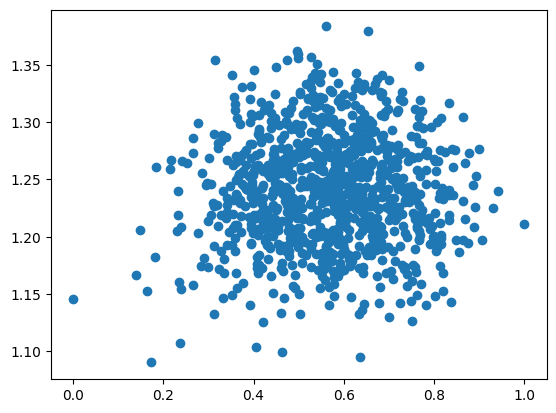

In [109]:
b = gb(1,1000)

import matplotlib.pyplot as plt

plt.scatter(b.x[0,:,0], b.y[0])

In [ ]:
import ast

# Assume r is a string containing code between ```python and ```
# Extract the code between the code block markers
def extract_python_code(code_str):
    start = code_str.find("```python")
    if start == -1:
        raise ValueError("No ```python code block found in r")
    start += len("```python")
    end = code_str.find("```", start)
    if end == -1:
        raise ValueError("No closing ``` found in r")
    code = code_str[start:end].strip()
    return code

code_str = extract_python_code(r)
parsed_code = ast.parse(code_str)

torch.Size([100, 100, 1])

In [118]:
c.priors[0]
p = AdhocPriorConfig(prior_names=c.priors[0].prior_names, prior_kwargs={**c.priors[0].prior_kwargs, 'batch_size_per_gp_sample': 1, 'hyperparameters': {**c.priors[0].prior_kwargs['hyperparameters']}})
gb = p.create_get_batch_method()

In [122]:
%time for i in range(10): gb(100,100)

CPU times: user 16.8 s, sys: 3.19 s, total: 20 s
Wall time: 2.06 s


In [123]:
import cProfile
import pstats
import io

pr = cProfile.Profile()
pr.enable()
gb(100, 100)
pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats("cumulative")
ps.print_stats(30)  # print top 30 functions by cumulative time
print(s.getvalue())


         1157354 function calls (1072044 primitive calls) in 0.452 seconds

   Ordered by: cumulative time
   List reduced from 609 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      3/2    0.000    0.000    0.452    0.226 /opt/anaconda3/envs/pfns/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3513(run_code)
        2    0.000    0.000    0.452    0.226 {built-in method builtins.exec}
        1    0.000    0.000    0.452    0.452 /Users/sammuller/Documents/PFNs/pfns/priors/utils.py:325(__call__)
        1    0.003    0.003    0.451    0.451 <string>:1(get_batch)
      100    0.001    0.000    0.432    0.004 /opt/anaconda3/envs/pfns/lib/python3.13/site-packages/torch/utils/_contextlib.py:113(decorate_context)
      100    0.006    0.000    0.431    0.004 /Users/sammuller/Documents/PFNs/pfns/priors/hebo_prior.py:241(get_batch)
      100    0.000    0.000    0.290    0.003 /Users/sammuller/Documents/PFNs/pfns/priors/

In [44]:
from pfns.priors.hebo_prior import get_model

%timeit get_model(torch.rand(10, 100, 3),  torch.rand(10, 100), {'lengthscale_mean': 1.1817737730161983, 'lengthscale_std': 1.0057682746685093, 'outputscale_mean': 1.5778822627887243, 'outputscale_std': 1.0882855543936365, 'add_linear_kernel': 0.20636056339165398, 'unused_feature_likelihood': 0.2863813077021147, 'observation_noise': False, 'x_sampler': 'normal', 'batch_size_per_gp_sample': 8, 'hebo_noise_logmean': -4.741929589778752, 'hebo_noise_std': 1.208457972746441}, sample=True, no_deepcopy=False)

x.shape=torch.Size([10, 100, 3]), y.shape=torch.Size([10, 100]), hyperparameters={'lengthscale_mean': 1.1817737730161983, 'lengthscale_std': 1.0057682746685093, 'outputscale_mean': 1.5778822627887243, 'outputscale_std': 1.0882855543936365, 'add_linear_kernel': 0.20636056339165398, 'unused_feature_likelihood': 0.2863813077021147, 'observation_noise': False, 'x_sampler': 'normal', 'batch_size_per_gp_sample': 8, 'hebo_noise_logmean': -4.741929589778752, 'hebo_noise_std': 1.208457972746441}
x.shape=torch.Size([10, 100, 3]), y.shape=torch.Size([10, 100]), hyperparameters={'lengthscale_mean': 1.1817737730161983, 'lengthscale_std': 1.0057682746685093, 'outputscale_mean': 1.5778822627887243, 'outputscale_std': 1.0882855543936365, 'add_linear_kernel': 0.20636056339165398, 'unused_feature_likelihood': 0.2863813077021147, 'observation_noise': False, 'x_sampler': 'normal', 'batch_size_per_gp_sample': 8, 'hebo_noise_logmean': -4.741929589778752, 'hebo_noise_std': 1.208457972746441}
x.shape=torch.Si

In [66]:
import torch
from pfns.priors.hebo_prior import get_model

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)

params = {
    'lengthscale_mean': 1.1817737730161983,
    'lengthscale_std': 1.0057682746685093,
    'outputscale_mean': 1.5778822627887243,
    'outputscale_std': 1.0882855543936365,
    'add_linear_kernel': 0.20636056339165398,
    'unused_feature_likelihood': 0.2863813077021147,
    'observation_noise': False,
    'x_sampler': 'normal',
    'batch_size_per_gp_sample': 8,
    'hebo_noise_logmean': -4.741929589778752,
    'hebo_noise_std': 1.208457972746441,
}

x = torch.rand(10, 100, 3)
y = torch.rand(10, 100)

# Get model with no_deepcopy=False
torch.manual_seed(seed)
model1, likelihood1 = get_model(x, y, params, sample=True, no_deepcopy=False)

# Get model with no_deepcopy=True
torch.manual_seed(seed)
model2, likelihood2 = get_model(x, y, params, sample=True, no_deepcopy=True)

# Compare all parameters
def models_equal(m1, m2):
    for (n1, p1), (n2, p2) in zip(m1.named_parameters(), m2.named_parameters()):
        if n1 != n2 or not torch.allclose(p1, p2):
            print(f"Difference in parameter {n1}")
            return False
    return True

assert models_equal(model1, model2), "Models are not equal with same seed and different no_deepcopy settings!"

print("Test passed: Models are identical with same seed regardless of no_deepcopy.")


x.shape=torch.Size([10, 100, 3]), y.shape=torch.Size([10, 100]), hyperparameters={'lengthscale_mean': 1.1817737730161983, 'lengthscale_std': 1.0057682746685093, 'outputscale_mean': 1.5778822627887243, 'outputscale_std': 1.0882855543936365, 'add_linear_kernel': 0.20636056339165398, 'unused_feature_likelihood': 0.2863813077021147, 'observation_noise': False, 'x_sampler': 'normal', 'batch_size_per_gp_sample': 8, 'hebo_noise_logmean': -4.741929589778752, 'hebo_noise_std': 1.208457972746441}
x.shape=torch.Size([10, 100, 3]), y.shape=torch.Size([10, 100]), hyperparameters={'lengthscale_mean': 1.1817737730161983, 'lengthscale_std': 1.0057682746685093, 'outputscale_mean': 1.5778822627887243, 'outputscale_std': 1.0882855543936365, 'add_linear_kernel': 0.20636056339165398, 'unused_feature_likelihood': 0.2863813077021147, 'observation_noise': False, 'x_sampler': 'normal', 'batch_size_per_gp_sample': 8, 'hebo_noise_logmean': -4.741929589778752, 'hebo_noise_std': 1.208457972746441}
Test passed: Mod

In [154]:
# spike prior
import torch
from pfns.priors import prior


def sample_datasets(batch_size, seq_len, num_features=1):
    x = torch.rand(batch_size, seq_len, num_features)
    peak_points = torch.rand(batch_size, num_features)
    slope = torch.rand(batch_size, num_features) * 100.
    y = 1-((x-peak_points[:,None]) * slope[:,None]).square().mean(-1).sqrt()
    y = y.clamp(min=0)
    return prior.Batch(x, y, y)


torch.Size([10, 10000, 1]) torch.Size([10, 10000])
torch.Size([10, 10000, 1]) torch.Size([10, 10000])


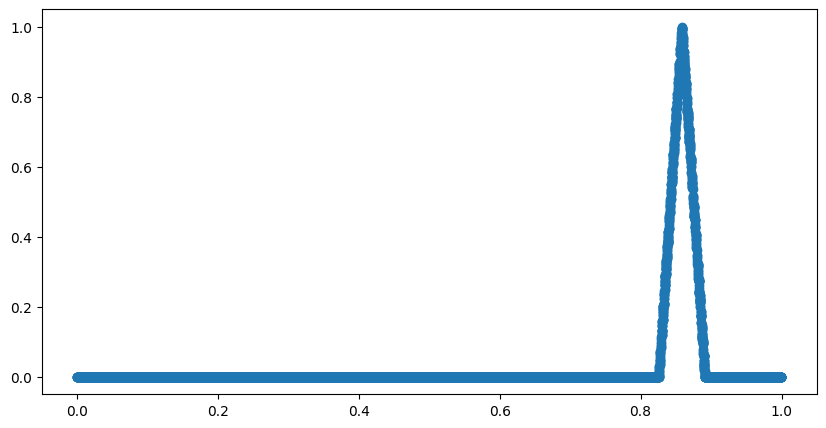

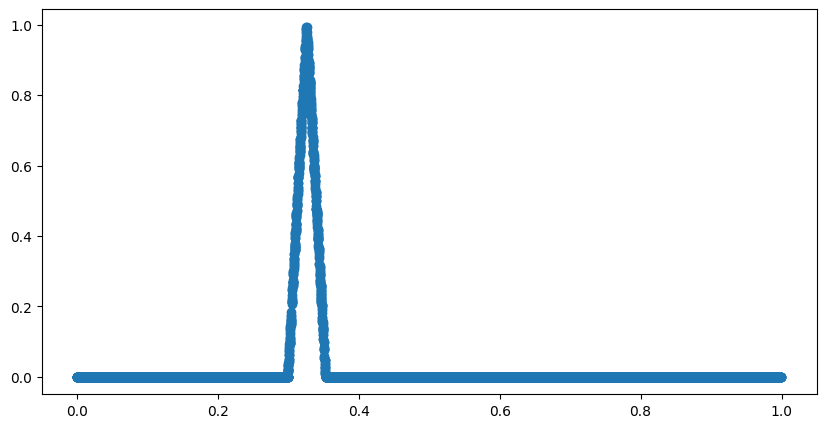

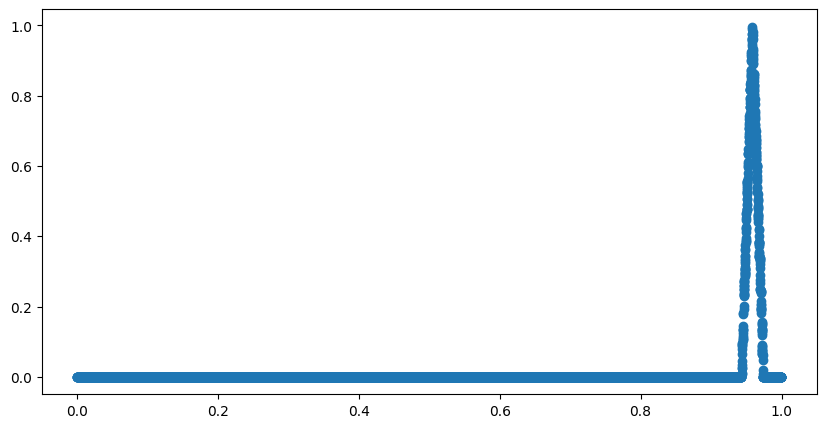

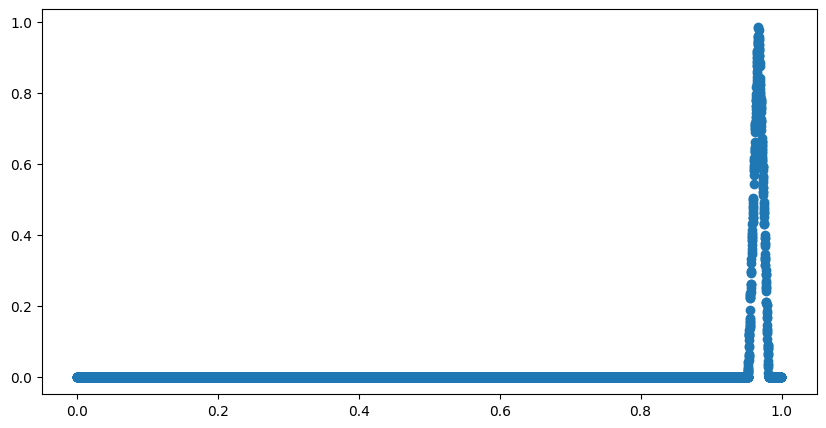

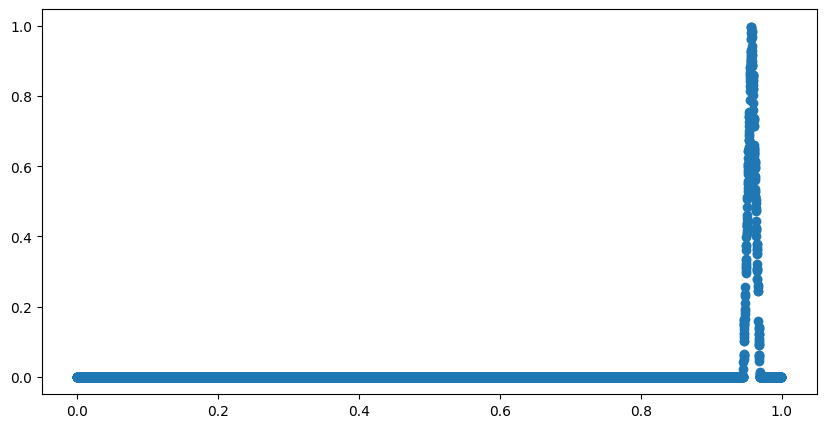

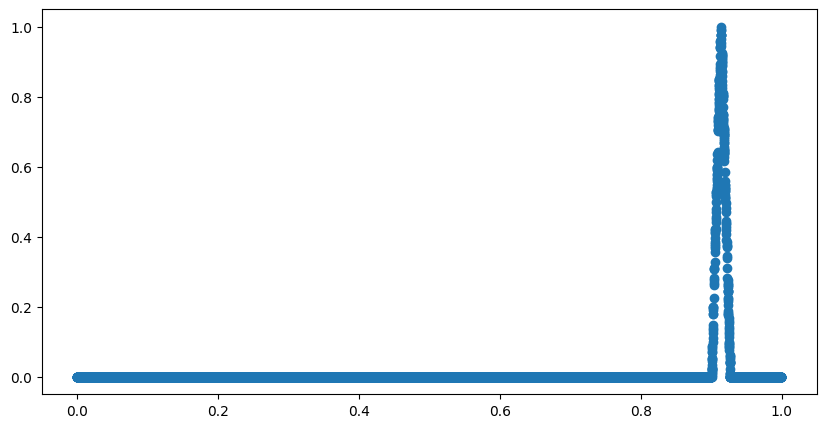

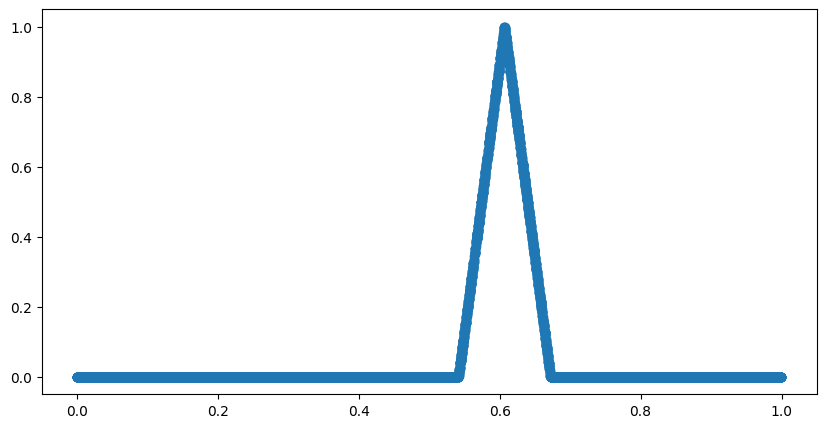

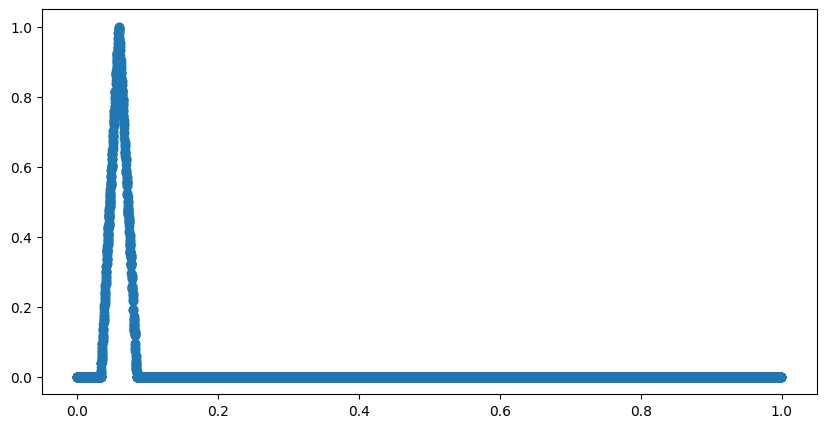

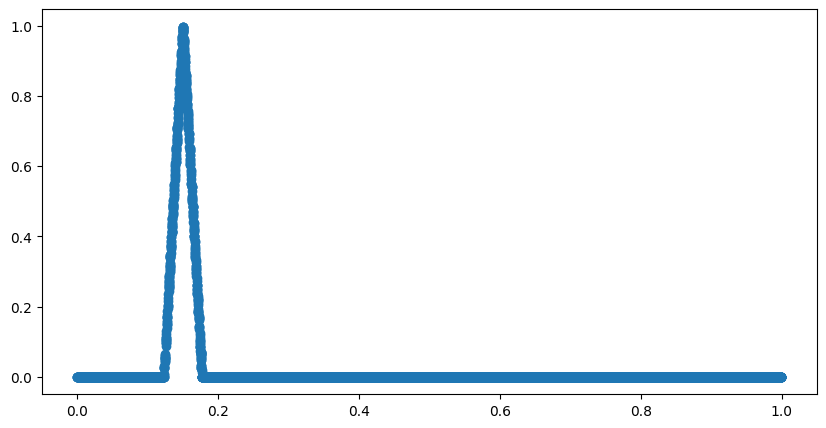

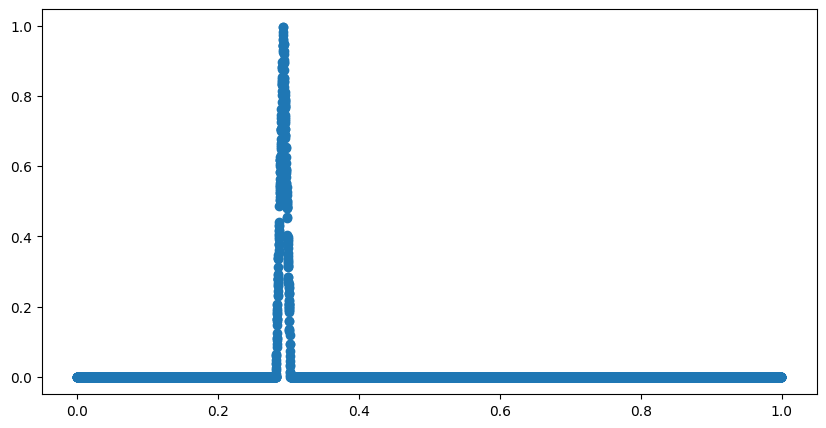

In [159]:
b = sample_datasets(10,10000, num_features=1)
x = b.x
y = b.y
print(x.shape, y.shape)

print(x.shape, y.shape)
import matplotlib.pyplot as plt

for i in range(len(x)):
    plt.figure(figsize=(10,5))
    #plt.scatter(x[i,:,0], x[i,:,1], c=y[i])
    plt.scatter(x[i,:,0], y[i])
    plt.show()

In [172]:
from torch import nn

offset = .7
x = torch.tensor([[offset], [offset + .01], [offset + .001]])
embs = nn.Linear(1,10, bias=False, dtype=torch.half)(x.half())
k = nn.Linear(10,10, bias=False, dtype=torch.half)(embs)
q = nn.Linear(10,10, bias=False, dtype=torch.half)(embs)


# def score_mode(score):
#     return 

# 

(embs @ embs.T).softmax(1), \
((embs @ embs.T) - (embs.square().sum(-1, keepdim=True))).softmax(1), \
(q @ k.T).softmax(1), \
((q @ k.T) - ((q * k).sum(-1, keepdim=True))).softmax(1)

(tensor([[0.3323, 0.3352, 0.3325],
         [0.3323, 0.3350, 0.3325],
         [0.3323, 0.3352, 0.3325]], dtype=torch.float16,
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.3323, 0.3352, 0.3325],
         [0.3323, 0.3350, 0.3325],
         [0.3323, 0.3352, 0.3325]], dtype=torch.float16,
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.3335, 0.3333, 0.3335],
         [0.3335, 0.3333, 0.3335],
         [0.3335, 0.3333, 0.3335]], dtype=torch.float16,
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.3335, 0.3333, 0.3335],
         [0.3335, 0.3333, 0.3335],
         [0.3335, 0.3333, 0.3335]], dtype=torch.float16,
        grad_fn=<SoftmaxBackward0>))

In [169]:
(embs*embs).sum(-1, keepdim=True)

tensor([[0.9326],
        [0.9590],
        [0.9355]], dtype=torch.float16, grad_fn=<SumBackward1>)

In [168]:
embs @ embs.T

tensor([[0.9331, 0.9458, 0.9341],
        [0.9458, 0.9590, 0.9473],
        [0.9341, 0.9473, 0.9355]], dtype=torch.float16, grad_fn=<MmBackward0>)

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

from typing import Optional

import torch
from torch import nn


class RotaryPositionalEmbeddings(nn.Module):
    """
    This class implements Rotary Positional Embeddings (RoPE)
    proposed in https://arxiv.org/abs/2104.09864.

    Reference implementation (used for correctness verfication)
    can be found here:
    https://github.com/meta-llama/llama/blob/main/llama/model.py#L80

    In this implementation we cache the embeddings for each position upto
    ``max_seq_len`` by computing this during init.

    Args:
        dim (int): Embedding dimension. This is usually set to the dim of each
            head in the attention module computed as ``embed_dim // num_heads``
        max_seq_len (int): Maximum expected sequence length for the
            model, if exceeded the cached freqs will be recomputed
        base (int): The base for the geometric progression used to compute
            the rotation angles
    """

    def __init__(
        self,
        dim: int,
        max_seq_len: int = 4096,
        base: int = 10_000,
    ) -> None:
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_seq_len = max_seq_len
        self.rope_init()

    # TODO: delete this once all our recipes are moved off of FSDP1 since we
    # no longer need to explicitly name our param init method reset_parameters
    def reset_parameters(self):
        self.rope_init()

    def rope_init(self):
        theta = 1.0 / (
            self.base
            ** (torch.arange(0, self.dim, 2)[: (self.dim // 2)].float() / self.dim)
        )
        self.register_buffer("theta", theta, persistent=False)
        self.build_rope_cache(self.max_seq_len)

    def build_rope_cache(self, max_seq_len: int = 4096) -> None:
        # Create position indexes `[0, 1, ..., max_seq_len - 1]`
        seq_idx = torch.arange(
            max_seq_len, dtype=self.theta.dtype, device=self.theta.device
        )

        # Outer product of theta and position index; output tensor has
        # a shape of [max_seq_len, dim // 2]
        idx_theta = torch.einsum("i, j -> ij", seq_idx, self.theta).float()

        # cache includes both the cos and sin components and so the output shape is
        # [max_seq_len, dim // 2, 2]
        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        self.register_buffer("cache", cache, persistent=False)

    def forward(
        self, x: torch.Tensor, *, input_pos: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): input tensor with shape
                ``[b, s, n_h, h_d]``
            input_pos (Optional[torch.Tensor]): Optional tensor which contains the position ids
                of each token. During training, this is used to indicate the positions
                of each token relative to its sample when packed, shape [b, s].
                During inference, this indicates the position of the current token.
                If none, assume the index of the token is its position id. Default is None.

        Returns:
            torch.Tensor: output tensor with shape ``[b, s, n_h, h_d]``

        Notation used for tensor shapes:
            - b: batch size
            - s: sequence length
            - n_h: num heads
            - h_d: head dim
        """
        # input tensor has shape [b, s, n_h, h_d]
        seq_len = x.size(1)

        # extract the values based on whether input_pos is set or not
        rope_cache = (
            self.cache[:seq_len] if input_pos is None else self.cache[input_pos]
        )

        # reshape input; the last dimension is used for computing the output.
        # Cast to float to match the reference implementation
        # tensor has shape [b, s, n_h, h_d // 2, 2]
        xshaped = x.float().reshape(*x.shape[:-1], -1, 2)

        # reshape the cache for broadcasting
        # tensor has shape [b, s, 1, h_d // 2, 2] if packed samples,
        # otherwise has shape [1, s, 1, h_d // 2, 2]
        rope_cache = rope_cache.view(-1, xshaped.size(1), 1, xshaped.size(3), 2)

        # tensor has shape [b, s, n_h, h_d // 2, 2]
        x_out = torch.stack(
            [
                xshaped[..., 0] * rope_cache[..., 0]
                - xshaped[..., 1] * rope_cache[..., 1],
                xshaped[..., 1] * rope_cache[..., 0]
                + xshaped[..., 0] * rope_cache[..., 1],
            ],
            -1,
        )

        # tensor has shape [b, s, n_h, h_d]
        x_out = x_out.flatten(3)
        return x_out.type_as(x)

In [ ]:
def apply_rope(x, inputs, base: int = 10_000):
    # inputs has to have shape [b,s,1]
    # x has shape [b,s,dim]

    b, s, dim = x.shape
    assert (dim // 2) * 2 == dim

    theta = 1000.0 / (base ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

    deg = torch.einsum("bs,d->bsd", inputs.squeeze(-1), theta)

    rope_vals = torch.stack([torch.cos(deg), torch.sin(deg)], dim=-1)  # b s d/2 2

    x = x.reshape(b, s, -1, 2)

    return torch.stack(
        [
            x[..., 0] * rope_vals[..., 0] - x[..., 1] * rope_vals[..., 1],
            x[..., 1] * rope_vals[..., 0] + x[..., 0] * rope_vals[..., 1],
        ],
        -1,
    ).view(b, s, dim)


# broken, somehow returning large values when feeding large inputs (but they should go through a sin/cos)

roped = apply_rope(x =torch.ones(1, 100, 32)/1.4, inputs=torch.linspace(0, 1, 100)[None, :, None])

tensor([1.0000e+03, 5.6234e+02, 3.1623e+02, 1.7783e+02, 1.0000e+02, 5.6234e+01,
        3.1623e+01, 1.7783e+01, 1.0000e+01, 5.6234e+00, 3.1623e+00, 1.7783e+00,
        1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01])
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0101e+01, 5.6802e+00, 3.1942e+00,  ..., 5.6802e-03,
          3.1942e-03, 1.7962e-03],
         [2.0202e+01, 1.1360e+01, 6.3884e+00,  ..., 1.1360e-02,
          6.3884e-03, 3.5925e-03],
         ...,
         [9.7980e+02, 5.5098e+02, 3.0984e+02,  ..., 5.5098e-01,
          3.0984e-01, 1.7424e-01],
         [9.8990e+02, 5.5666e+02, 3.1303e+02,  ..., 5.5666e-01,
          3.1303e-01, 1.7603e-01],
         [1.0000e+03, 5.6234e+02, 3.1623e+02,  ..., 5.6234e-01,
          3.1623e-01, 1.7783e-01]]])
tensor([[[[ 1.0000,  0.0000],
          [ 1.0000,  0.0000],
          [ 1.0000,  0.0000],
          ...,
          [ 1.0000,  0.0000],
          [ 1.0000,  0.0000],
        

In [47]:
roped.squeeze(0)

tensor([[ 0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143],
        [-0.1101, -1.0041, -0.2251,  0.9848,  0.6386,  0.7827,  0.7070,  0.7215],
        [-0.5426,  0.8520, -0.9537,  0.3331,  0.5564,  0.8431,  0.6997,  0.7286],
        [ 0.9565, -0.3249, -0.7892, -0.6305,  0.4686,  0.8949,  0.6923,  0.7356],
        [-0.9493, -0.3452,  0.1143, -1.0037,  0.3760,  0.9376,  0.6849,  0.7426],
        [ 0.5244,  0.8634,  0.9108, -0.4369,  0.2795,  0.9707,  0.6773,  0.7494],
        [ 0.1314, -1.0016,  0.8543,  0.5390,  0.1802,  0.9940,  0.6697,  0.7562],
        [-0.7293,  0.6990, -0.0021,  1.0102,  0.0790,  1.0071,  0.6620,  0.7630],
        [ 1.0063, -0.0887, -0.8566,  0.5354, -0.0229,  1.0099,  0.6543,  0.7696],
        [-0.8403, -0.5606, -0.9089, -0.4408, -0.1246,  1.0024,  0.6465,  0.7762],
        [ 0.3046,  0.9631, -0.1101, -1.0041, -0.2251,  0.9848,  0.6386,  0.7827],
        [ 0.3653, -0.9418,  0.7919, -0.6272, -0.3232,  0.9570,  0.6307,  0.7891],
        [-0.8743

In [201]:
r = RotaryPositionalEmbeddings(128)
r.theta

tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.7384e-03,
        2.3714e-03, 2.0535e-03, 1.7783e-03, 1.5399e-03, 1.3335e-03, 1.1548e-03,
        1.0000e-03, 8.6596e-04, 7.4989e-04, 6.4938e-04, 5.6234e-04, 4.8697e-04,
        4.2170e-04, 3.6517e-04, 3.1623e-04, 2.7384e-04, 2.3714e-04, 2.0535e-04,
        1.7783e-04, 1.5399e-04, 1.3335e-04, 1.1548e-04])

In [188]:
r.cache

tensor([[[ 1.0000,  0.0000],
         [ 1.0000,  0.0000],
         [ 1.0000,  0.0000]],

        [[ 0.5403,  0.8415],
         [ 0.9989,  0.0464],
         [ 1.0000,  0.0022]],

        [[-0.4161,  0.9093],
         [ 0.9957,  0.0927],
         [ 1.0000,  0.0043]],

        ...,

        [[-0.8799,  0.4752],
         [ 0.0860,  0.9963],
         [-0.8215,  0.5701]],

        [[-0.8753, -0.4836],
         [ 0.0397,  0.9992],
         [-0.8228,  0.5684]],

        [[-0.0660, -0.9978],
         [-0.0067,  1.0000],
         [-0.8240,  0.5666]]])

In [200]:
r.theta

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])

In [199]:
r.forward(torch.ones(1,1024,1,32))[:,:,:,:6]

tensor([[[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]],

         [[-0.3012,  1.3818,  0.3128,  1.3792,  0.6394,  1.2614]],

         [[-1.3254,  0.4932, -0.4707,  1.3336,  0.2155,  1.3977]],

         ...,

         [[-1.0175, -0.9822, -1.4138, -0.0346, -1.4108, -0.0988]],

         [[ 0.2768, -1.3869, -1.1777, -0.7830, -1.3101, -0.5326]],

         [[ 1.3166, -0.5164, -0.5788, -1.2904, -1.0795, -0.9136]]]])

In [ ]:
from pfns.model.transformer_config import TransformerConfig, CrossEntropyConfig

TransformerConfig(
    criterion=CrossEntropyConfig(num_classes=3),
    use_rope=True,
).create_model().use_rope

Using linear x encoder, as no encoder was provided.
Using linear y encoder, as no y_encoder was provided.
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False


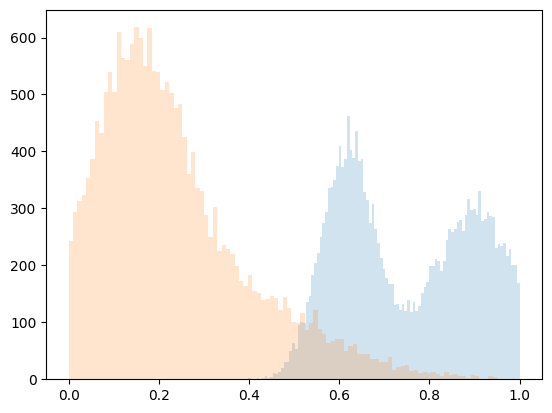

In [68]:
import torch
from matplotlib import pyplot as plt


def sample_clustered_x(batch_size, seq_len, num_features, pad_factor=10.):
    """
    This function samples a batch of inputs from normal distributions.
    Its outputs are all in [0,1], which is ensured by over-sampling (pad_factor)
    and then rejecting outside samples. In addition, we clamp the values to [0,1].
    """
    mean = torch.rand(batch_size, num_features)
    std = torch.rand(batch_size, num_features) / 4.

    x = torch.randn(batch_size, num_features, seq_len * pad_factor) * std[:,:,None] + mean[:,:,None]
    sorting_x = ((x >= 0.) & (x <= 1.))
    order = torch.argsort(sorting_x, dim=-1, stable=True, descending=True)
    x = x.gather(dim=-1, index=order[:,:,:seq_len])
    x = x.transpose(1,2)
    x = x.clamp(0,1)
    return x

batch_size = 2
seq_len = 10_000
num_features = 2

pad_factor = 10

x = sample_clustered_x(batch_size, seq_len, num_features, pad_factor)


for x_ in x:
    plt.hist(x_.flatten(), alpha=.2, bins=100)
plt.show()

In [ ]:
from pfns.train import MainConfig, OptimizerConfig


MainConfig(
    priors=[],
    optimizer=OptimizerConfig(
        optimizer='adam',
        lr=0.001,
    ),
    model=TransformerConfig(
        use_rope=True,
        criterion=CrossEntropyConfig(num_classes=3),
    ),
)

In [27]:
x.shape

torch.Size([2, 10000, 2])

In [8]:
x.shape

torch.Size([2, 10000, 1])

In [6]:
import torch

def get_rope_vals(inputs: torch.Tensor, dim: int, base: int = 10_000):
    # inputs has to have shape [b]

    assert (dim // 2) * 2 == dim, f"{dim=} not divisible by 2"

    theta = 1000.0 / (
        base
        ** (torch.arange(0, dim, 2, device=inputs.device)[: (dim // 2)].float() / dim)
    )

    deg = torch.einsum("b,d->bd", inputs, theta)

    rope_vals = torch.stack([torch.cos(deg), torch.sin(deg)], dim=-1)  # b d/2 2

    return rope_vals.view(-1, dim)

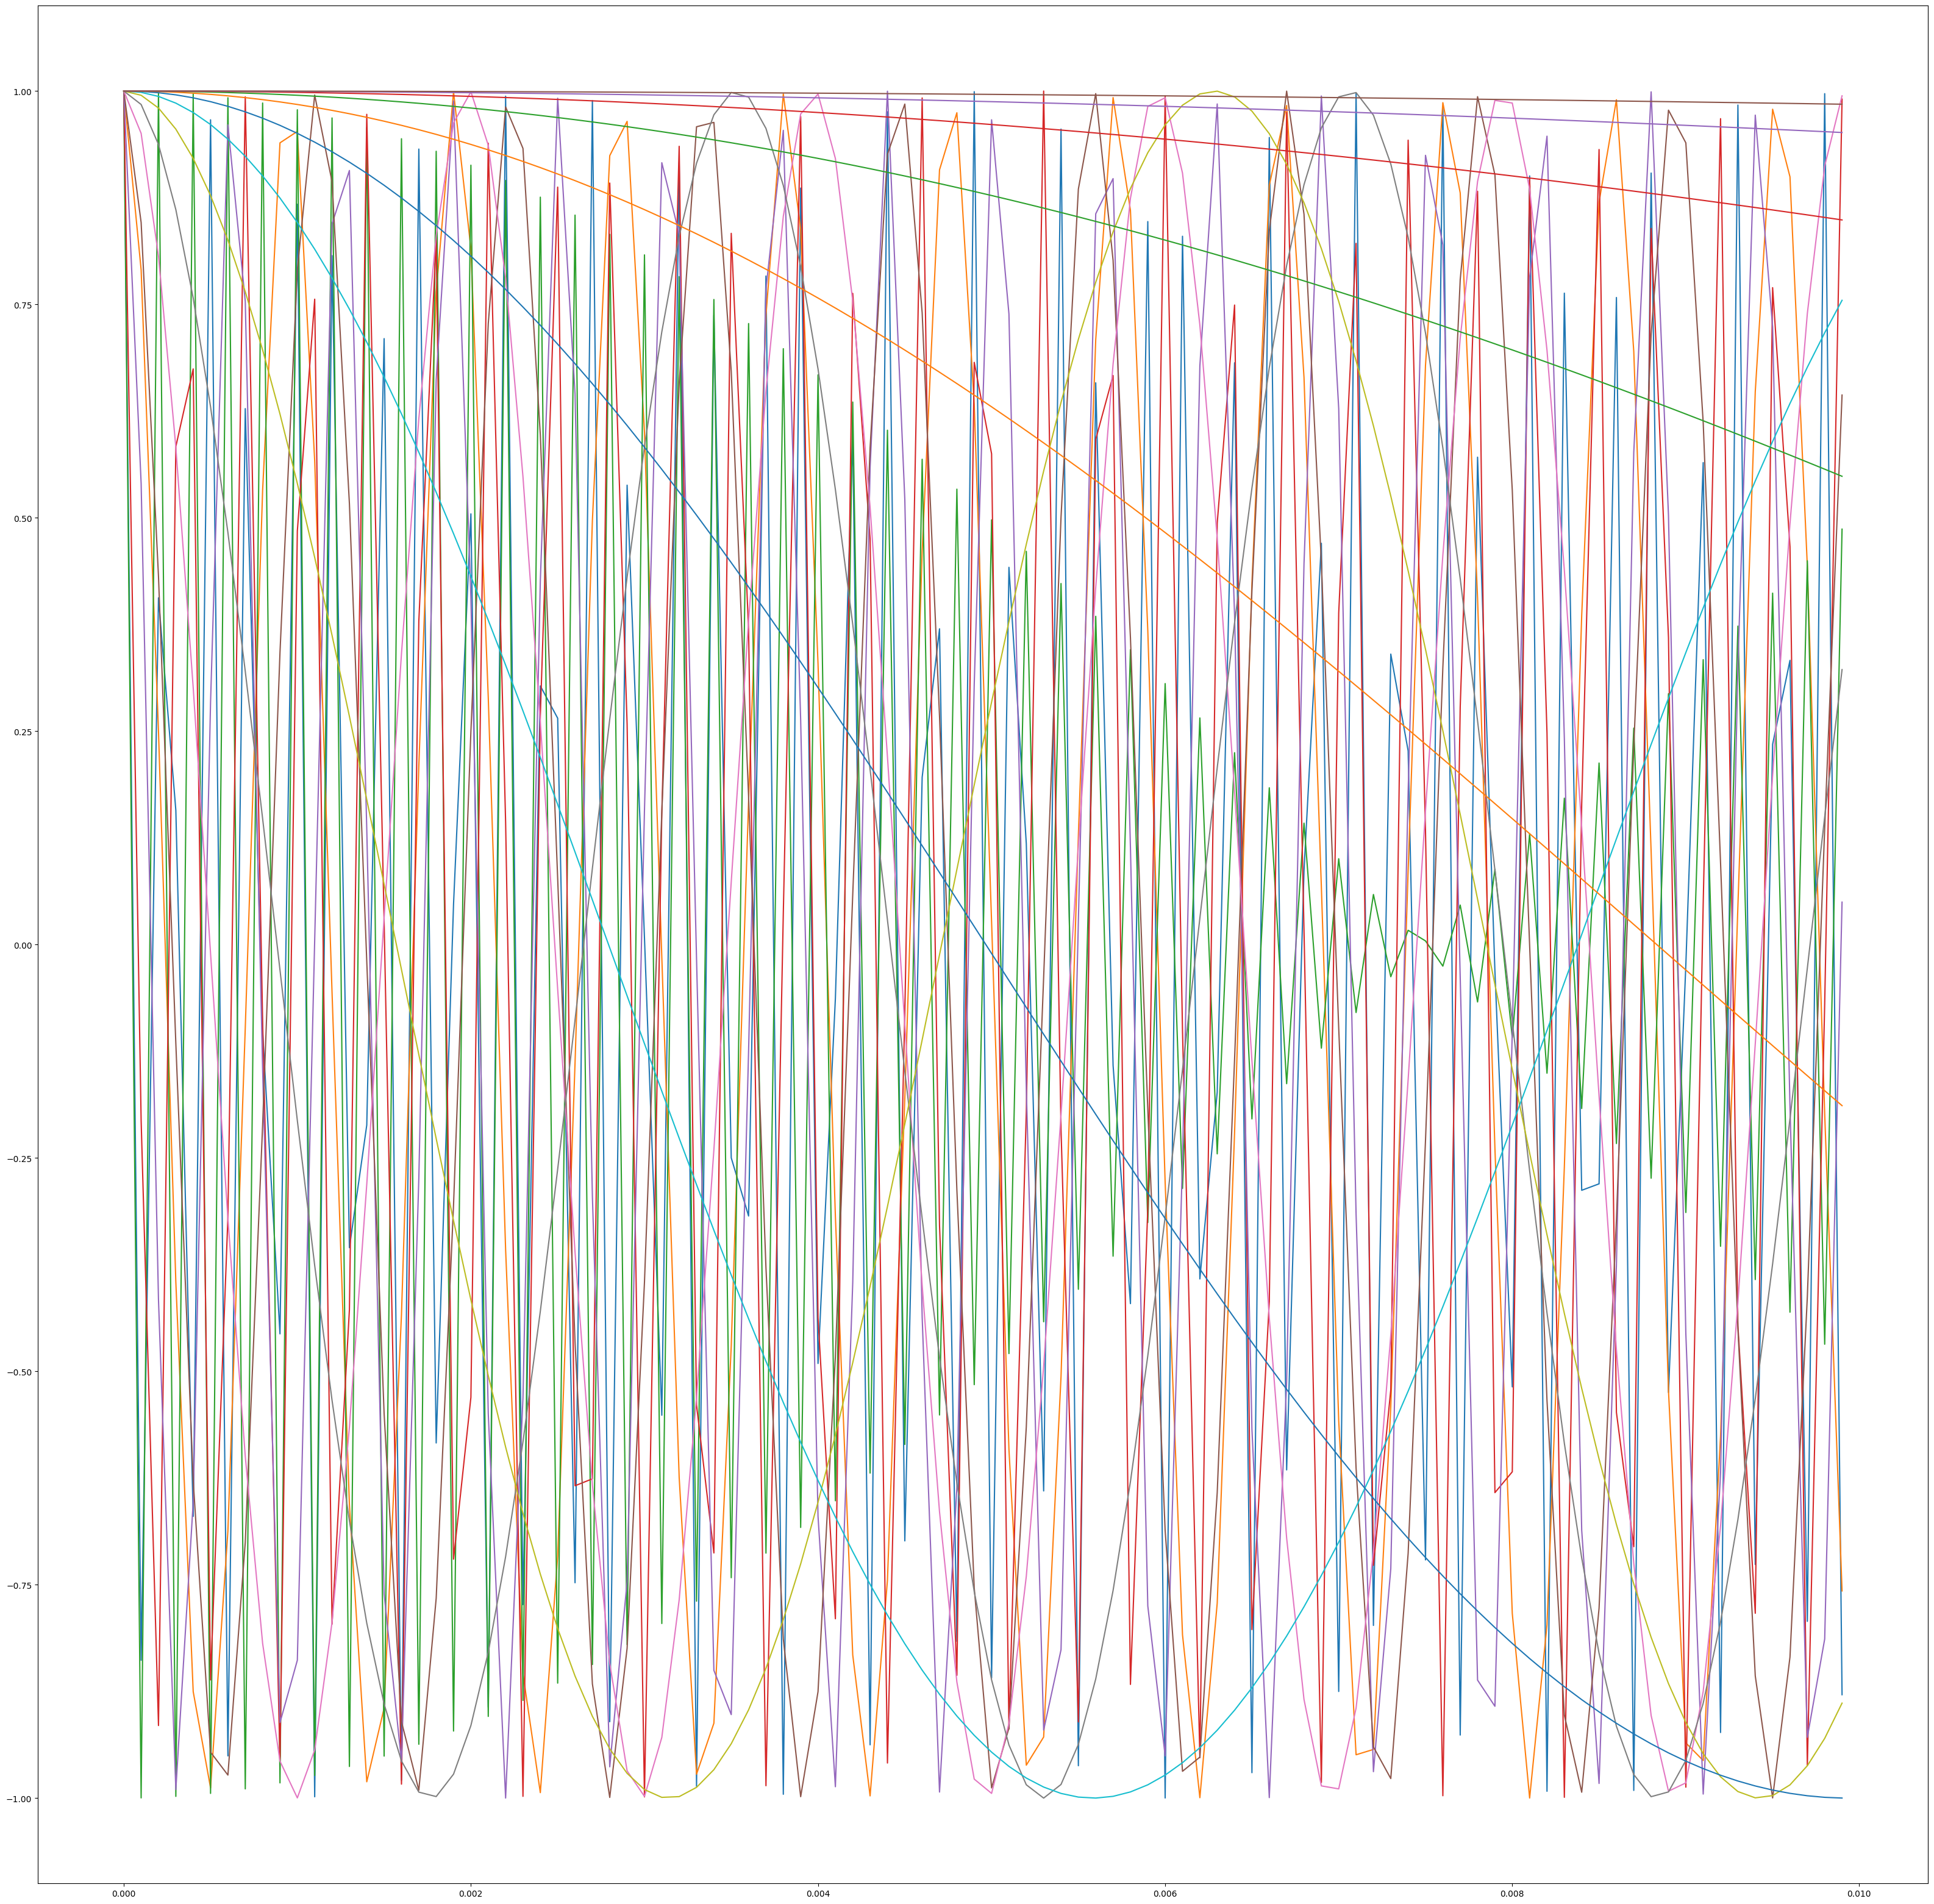

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
torch.set_printoptions(linewidth=200)
samples = 10_000
points = torch.linspace(0, 1, samples)

multiplier = 100 # 1000
base = 10_000 #1000

rope = get_rope_vals(points*multiplier, 32, base=base).view(samples, -1, 2)[:,:,0]

for i in range(rope.shape[1]):
    plt.plot(points[:100], rope[:100, i])
# plt.plot(rope[:100,0])
# plt.plot(rope[:100,1])
plt.show()

In [45]:
rope[:2]

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.8385,  0.7905, -0.9998, -0.2062,  0.5402,  0.8460,  0.9504,  0.9842,  0.9950,  0.9984,  0.9995,  0.9998,  0.9999,  1.0000,  1.0000,  1.0000]])

In [35]:
rope.shape

torch.Size([10000, 4])

In [4]:
CrossEntropyConfig(3)

TypeError: CrossEntropyConfig() takes no arguments

In [1]:
from pfns.model.transformer import TableTransformer

def encoder(x, **kwargs):
    r = x['main'].repeat(1,1,4) + 1
    r[:,:,:4//2] = -r[:,:,:4//2]
    return r

def y_encoder(x, **kwargs):
    r = x['main'].repeat(1,1,4).nan_to_num(100)
    r[:,:,:4//2] = -r[:,:,:4//2]
    return r

m = TableTransformer(
        encoder=encoder,
        nhead=2,
        ninp=4,
        nlayers=2,
        y_encoder=y_encoder,
        #style_encoder=style_encoder,
        #y_style_encoder=lambda x: x,
        use_rope=True,
        attention_between_features=True,
)

multiquery_item_attention_for_test_set=False, multiquery_item_attention=False
multiquery_item_attention_for_test_set=False, multiquery_item_attention=False


In [2]:
import torch

x = torch.arange(3).float()[None,:,None].repeat(1,1,2)
y = torch.zeros_like(x[:,:2,0]) + 1
#style = torch.arange(3).float()[None, :,None] + 1 + 3 * torch.arange(2).float()[None, None, :]
#y_style = torch.arange(8).float()[None]

print(x.shape, y.shape)

out = m(x=x, y=y)

torch.Size([1, 3, 2]) torch.Size([1, 2])
doing kv
doing kv


In [18]:
def get_rope_vals(inputs: torch.Tensor, dim: int, base: int = 10_000):
    # inputs has to have shape [b]

    assert (dim // 2) * 2 == dim, f"{dim=} not divisible by 2"

    theta = 1000.0 / (base ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

    deg = torch.einsum("b,d->bd", inputs, theta)

    rope_vals = torch.stack([torch.cos(deg), torch.sin(deg)], dim=-1)  # b d/2 2
    print(f"{rope_vals=}")

    return rope_vals.view(-1, dim)

In [6]:
get_rope_vals(torch.arange(3).float(), 2)

rope_vals=tensor([[[ 1.0000,  0.0000]],

        [[ 0.5624,  0.8269]],

        [[-0.3675,  0.9300]]])


tensor([[ 1.0000,  0.0000],
        [ 0.5624,  0.8269],
        [-0.3675,  0.9300]])

In [3]:
out

tensor([[[-0.0544]]], grad_fn=<ViewBackward0>)

In [51]:
from pfns.model.transformer import PerFeatureTransformer

def style_encoder(style): # style shape: [batch size, features per group, style shape]
    return style.squeeze(1).repeat(1,4)

m = PerFeatureTransformer(
        encoder=lambda x, **kwargs: x['main'].repeat(1,1,8),
        ninp=8,
        y_encoder=lambda x, **kwargs: x['main'].repeat(1,1,8).nan_to_num(100),
        style_encoder=style_encoder,
        y_style_encoder=lambda x: x,

)

ImportError: cannot import name 'PerFeatureTransformer' from 'pfns.model.transformer' (/Users/sammuller/Documents/PFNs/pfns/model/transformer.py)

In [24]:
import torch

x = torch.arange(3).float()[None,None,:].repeat(2,1,1)
y = torch.zeros_like(x[:1,:,0])
style = torch.arange(3).float()[None, :,None] + 1 + 3 * torch.arange(2).float()[None, None, :]
y_style = torch.arange(8).float()[None]

print(x.shape, y.shape, style.shape)

m(x, y, style=style, y_style=y_style)

torch.Size([2, 1, 3]) torch.Size([1, 1]) torch.Size([1, 3, 2])
embedded_x.shape=torch.Size([1, 2, 3, 8]) embedded_x=tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [2., 2., 2., 2., 2., 2., 2., 2.]],

         [[0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [2., 2., 2., 2., 2., 2., 2., 2.]]]])
torch.Size([1, 1, 3, 8]) torch.Size([1, 1, 1, 8])
embedded_input.shape=torch.Size([1, 3, 4, 8]) embedded_input=tensor([[[[  1.,   4.,   1.,   4.,   1.,   4.,   1.,   4.],
          [  2.,   5.,   2.,   5.,   2.,   5.,   2.,   5.],
          [  3.,   6.,   3.,   6.,   3.,   6.,   3.,   6.],
          [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.]],

         [[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
          [  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],

         [[  0.,   0

tensor([[[0.0069]]], grad_fn=<ViewBackward0>)